In [1]:
#!/usr/bin/env python
from math import ceil
from random import uniform
import argparse
import os

import tensorflow as tf

from adain.nn import build_vgg, vgg_layer_params, build_decoder
from adain.norm import adain
from adain.util import get_params
from adain.weights import open_weights

import numpy as np
import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu


In [2]:
# Train Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")

def get_my_batch():
    global x_array, y_array
    
    perm    = np.random.permutation(len(x_array))
    x_array = np.array(x_array)[perm]
    y_array = np.array(y_array)[perm]
    
    content_images = []
    style_images   = []
    
    for i in range(8):
        temp = [x_array[i, :, :, 0], x_array[i, :, :, 0], x_array[i, :, :, 0]]
        content_images.append(temp)
        
        temp = [y_array[i, :, :, 0], y_array[i, :, :, 0], y_array[i, :, :, 0]]
        style_images.append(temp)
       
    #content_images = x_array[:8, :, :, 0]
    #style_images   = y_array[:8, :, :, 0]
    
    #content_images = np.concatenate([content_images, content_images, content_images], axis=-1)
    #style_images   = np.concatenate([style_images, style_images, style_images], axis=-1)
    
    return np.array(content_images), np.array(style_images)
    

def train(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=False,
        optimizer='adam',
        learning_rate=1e-4,
        learning_rate_decay=5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=1,
        content_weight=0.01,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)

    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)

    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)

    with open_weights(vgg) as w:
        vgg = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_layers = {layer: vgg[layer] for layer in style_layers}
    style_targets = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    loss = content_loss + tf.reduce_sum(list(style_losses.values()))

    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    loss += tv_loss


    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        if resume:
            latest = tf.train.latest_checkpoint(checkpoint_dir)
            saver.restore(sess, latest)
        else:
            sess.run(tf.global_variables_initializer())

        coord   = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        with coord.stop_on_exception():
            while not coord.should_stop():
                content_batch, style_batch = get_my_batch()
                #content_batch, style_batch = sess.run(batch)

                # step 1
                # encode content and style images,
                # compute target style activations,
                # run content and style through AdaIN
                content_batch_encoded = sess.run(encoder, feed_dict={
                    images: content_batch
                })

                style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
                    images: style_batch
                })

                output_batch_encoded = sess.run(output_encoded, feed_dict={
                    content_encoded: content_batch_encoded,
                    style_encoded: style_batch_encoded
                })

                # step 2
                # run the output batch through the decoder, compute loss
                feed_dict = {
                    output_encoded: output_batch_encoded,
                    # "We use the AdaIN output as the content target, instead of
                    # the commonly used feature responses of the content image"
                    content_target: output_batch_encoded
                }
                for layer in style_targets:
                    feed_dict[style_targets[layer]] = style_target_vals[layer]

                fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step]
                result = sess.run(fetches, feed_dict=feed_dict)
                _, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i = result

                if i % print_every == 0:
                    style_loss_val = sum(style_loss_vals.values())
                    style_loss_vals = '\t'.join(sorted(['%s = %0.4f' % (name, val) for name, val in style_loss_vals.items()]))
                    print(i,
                        'loss = %0.4f' % loss_val,
                        'content = %0.4f' % content_loss_val,
                        'style = %0.4f' % style_loss_val,
                        style_loss_vals,
                        'tv = %0.4f' % tv_loss_val, sep='\t')

                if i % save_every == 0:
                    print('Saving checkpoint')
                    saver.save(sess, os.path.join(checkpoint_dir, 'adain'), global_step=i)

        coord.join(threads)
        saver.save(sess, os.path.join(checkpoint_dir, 'adain-final'))


def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        mean_loss /= n
        std_loss /= n

        losses[layer] = (mean_loss + std_loss) * weight
    return losses




# if __name__ == '__main__':
#     params = get_params(train)

#     parser = argparse.ArgumentParser(description='AdaIN Style Transfer Training')

#     # general
#     parser.add_argument('--content_dir', default=params['content_dir'],
#         help='A directory with TFRecords files containing content images for training')
#     parser.add_argument('--style_dir', default=params['style_dir'],
#         help='A directory with TFRecords files containing style images for training')
#     parser.add_argument('--vgg', default=params['vgg'],
#         help='Path to the weights of the VGG19 network')
#     parser.add_argument('--checkpoint_dir', default=params['checkpoint_dir'],
#         help='Name of the checkpoint directory')
#     parser.add_argument('--decoder_activation', default=params['decoder_activation'],
#         help='Activation function in the decoder')
#     parser.add_argument('--gpu', default=params['gpu'], type=int,
#         help='Zero-indexed ID of the GPU to use')

#     # preprocessing
#     parser.add_argument('--initial_size', default=params['initial_size'],
#         type=int, help='Initial size of training images')
#     parser.add_argument('--random_crop_size', default=params['random_crop_size'], type=int,
#         help='Images will be randomly cropped to this size')

#     # training options
#     parser.add_argument('--resume', action='store_true',
#         help='If true, resume training from the last checkpoint')
#     parser.add_argument('--optimizer', default=params['optimizer'],
#         help='Optimizer used, adam or SGD')
#     parser.add_argument('--learning_rate', default=params['learning_rate'],
#         type=float, help='Learning rate')
#     parser.add_argument('--learning_rate_decay', default=params['learning_rate_decay'],
#         type=float, help='Learning rate decay')
#     parser.add_argument('--momentum', default=params['momentum'],
#         type=float, help='Momentum')
#     parser.add_argument('--batch_size', default=params['batch_size'],
#         type=int, help='Batch size')
#     parser.add_argument('--num_epochs', default=params['num_epochs'],
#         type=int, help='Number of epochs')
#     parser.add_argument('--content_layer', default=params['content_layer'],
#         help='Target content layer used to compute the loss')
#     parser.add_argument('--style_layers', default=params['style_layers'],
#         help='Target style layers used to compute the loss')
#     parser.add_argument('--tv_weight', default=params['tv_weight'],
#         type=float, help='Weight of the Total Variation loss')
#     parser.add_argument('--style_weight', default=params['style_weight'],
#         type=float, help='Weight of style loss')
#     parser.add_argument('--content_weight', default=params['content_weight'],
#         type=float, help='Weight of content loss')

#     parser.add_argument('--save_every', default=params['save_every'],
#         type=int, help='Save interval')
#     parser.add_argument('--print_every', default=params['print_every'],
#         type=int, help='Print interval')

#     args = parser.parse_args()
#     train(**vars(args))


In [3]:
train()

10	loss = 3.0971	content = 0.3299	style = 2.7672	conv1_1 = 0.0562	conv2_1 = 0.2133	conv3_1 = 0.8111	conv4_1 = 1.6867	tv = 0.0000
20	loss = 1.1455	content = 0.1088	style = 1.0367	conv1_1 = 0.0498	conv2_1 = 0.1572	conv3_1 = 0.2736	conv4_1 = 0.5561	tv = 0.0000
30	loss = 1.4020	content = 0.1383	style = 1.2637	conv1_1 = 0.0490	conv2_1 = 0.1620	conv3_1 = 0.3454	conv4_1 = 0.7073	tv = 0.0000
40	loss = 1.6630	content = 0.1593	style = 1.5038	conv1_1 = 0.0544	conv2_1 = 0.1939	conv3_1 = 0.4409	conv4_1 = 0.8146	tv = 0.0000
50	loss = 1.1765	content = 0.1153	style = 1.0612	conv1_1 = 0.0504	conv2_1 = 0.1603	conv3_1 = 0.2607	conv4_1 = 0.5898	tv = 0.0000
60	loss = 1.4067	content = 0.1390	style = 1.2677	conv1_1 = 0.0532	conv2_1 = 0.1715	conv3_1 = 0.3321	conv4_1 = 0.7109	tv = 0.0000
70	loss = 1.7392	content = 0.1759	style = 1.5633	conv1_1 = 0.0561	conv2_1 = 0.1893	conv3_1 = 0.4179	conv4_1 = 0.8999	tv = 0.0000
80	loss = 1.0966	content = 0.0996	style = 0.9970	conv1_1 = 0.0512	conv2_1 = 0.1647	conv3_1 = 0.27

650	loss = 1.6864	content = 0.1779	style = 1.5085	conv1_1 = 0.0472	conv2_1 = 0.1568	conv3_1 = 0.3946	conv4_1 = 0.9098	tv = 0.0000
660	loss = 1.1976	content = 0.1122	style = 1.0854	conv1_1 = 0.0526	conv2_1 = 0.1697	conv3_1 = 0.2894	conv4_1 = 0.5738	tv = 0.0000
670	loss = 1.4011	content = 0.1361	style = 1.2650	conv1_1 = 0.0545	conv2_1 = 0.1795	conv3_1 = 0.3349	conv4_1 = 0.6961	tv = 0.0000
680	loss = 1.3773	content = 0.1402	style = 1.2372	conv1_1 = 0.0476	conv2_1 = 0.1569	conv3_1 = 0.3156	conv4_1 = 0.7171	tv = 0.0000
690	loss = 2.0170	content = 0.2130	style = 1.8039	conv1_1 = 0.0503	conv2_1 = 0.1711	conv3_1 = 0.4931	conv4_1 = 1.0894	tv = 0.0000
700	loss = 1.5345	content = 0.1504	style = 1.3841	conv1_1 = 0.0515	conv2_1 = 0.1771	conv3_1 = 0.3862	conv4_1 = 0.7693	tv = 0.0000
710	loss = 1.7703	content = 0.1773	style = 1.5929	conv1_1 = 0.0515	conv2_1 = 0.1835	conv3_1 = 0.4508	conv4_1 = 0.9072	tv = 0.0000
720	loss = 1.8482	content = 0.1997	style = 1.6485	conv1_1 = 0.0486	conv2_1 = 0.1619	conv3_

1280	loss = 0.9843	content = 0.0920	style = 0.8922	conv1_1 = 0.0459	conv2_1 = 0.1448	conv3_1 = 0.2305	conv4_1 = 0.4709	tv = 0.0000
1290	loss = 2.4414	content = 0.2652	style = 2.1762	conv1_1 = 0.0534	conv2_1 = 0.1900	conv3_1 = 0.5770	conv4_1 = 1.3559	tv = 0.0000
1300	loss = 1.6249	content = 0.1621	style = 1.4628	conv1_1 = 0.0518	conv2_1 = 0.1813	conv3_1 = 0.4007	conv4_1 = 0.8290	tv = 0.0000
1310	loss = 1.0360	content = 0.0955	style = 0.9405	conv1_1 = 0.0477	conv2_1 = 0.1525	conv3_1 = 0.2518	conv4_1 = 0.4885	tv = 0.0000
1320	loss = 1.3508	content = 0.1325	style = 1.2183	conv1_1 = 0.0533	conv2_1 = 0.1720	conv3_1 = 0.3152	conv4_1 = 0.6779	tv = 0.0000
1330	loss = 2.5316	content = 0.2761	style = 2.2554	conv1_1 = 0.0521	conv2_1 = 0.1924	conv3_1 = 0.5987	conv4_1 = 1.4123	tv = 0.0000
1340	loss = 0.9141	content = 0.0800	style = 0.8341	conv1_1 = 0.0504	conv2_1 = 0.1563	conv3_1 = 0.2180	conv4_1 = 0.4094	tv = 0.0000
1350	loss = 1.5959	content = 0.1540	style = 1.4418	conv1_1 = 0.0533	conv2_1 = 0.177

1910	loss = 0.9857	content = 0.0895	style = 0.8962	conv1_1 = 0.0507	conv2_1 = 0.1582	conv3_1 = 0.2294	conv4_1 = 0.4579	tv = 0.0000
1920	loss = 1.7507	content = 0.1762	style = 1.5745	conv1_1 = 0.0523	conv2_1 = 0.1787	conv3_1 = 0.4421	conv4_1 = 0.9013	tv = 0.0000
1930	loss = 2.3107	content = 0.2558	style = 2.0549	conv1_1 = 0.0485	conv2_1 = 0.1703	conv3_1 = 0.5277	conv4_1 = 1.3083	tv = 0.0000
1940	loss = 2.5035	content = 0.2561	style = 2.2474	conv1_1 = 0.0514	conv2_1 = 0.1918	conv3_1 = 0.6947	conv4_1 = 1.3096	tv = 0.0000
1950	loss = 0.9796	content = 0.0917	style = 0.8879	conv1_1 = 0.0465	conv2_1 = 0.1461	conv3_1 = 0.2264	conv4_1 = 0.4689	tv = 0.0000
1960	loss = 1.6406	content = 0.1601	style = 1.4805	conv1_1 = 0.0531	conv2_1 = 0.1789	conv3_1 = 0.4298	conv4_1 = 0.8187	tv = 0.0000
1970	loss = 1.2854	content = 0.1238	style = 1.1616	conv1_1 = 0.0490	conv2_1 = 0.1629	conv3_1 = 0.3166	conv4_1 = 0.6332	tv = 0.0000
1980	loss = 1.8903	content = 0.1951	style = 1.6952	conv1_1 = 0.0539	conv2_1 = 0.184

2540	loss = 1.9924	content = 0.2102	style = 1.7823	conv1_1 = 0.0501	conv2_1 = 0.1755	conv3_1 = 0.4813	conv4_1 = 1.0753	tv = 0.0000
2550	loss = 2.2585	content = 0.2390	style = 2.0196	conv1_1 = 0.0516	conv2_1 = 0.1848	conv3_1 = 0.5613	conv4_1 = 1.2219	tv = 0.0000
2560	loss = 0.8674	content = 0.0787	style = 0.7887	conv1_1 = 0.0459	conv2_1 = 0.1419	conv3_1 = 0.1981	conv4_1 = 0.4027	tv = 0.0000
2570	loss = 1.7769	content = 0.1762	style = 1.6007	conv1_1 = 0.0576	conv2_1 = 0.1968	conv3_1 = 0.4451	conv4_1 = 0.9012	tv = 0.0000
2580	loss = 1.8470	content = 0.1772	style = 1.6698	conv1_1 = 0.0616	conv2_1 = 0.2103	conv3_1 = 0.4916	conv4_1 = 0.9063	tv = 0.0000
2590	loss = 1.8179	content = 0.1809	style = 1.6370	conv1_1 = 0.0571	conv2_1 = 0.1906	conv3_1 = 0.4644	conv4_1 = 0.9249	tv = 0.0000
2600	loss = 1.7841	content = 0.1789	style = 1.6052	conv1_1 = 0.0534	conv2_1 = 0.1849	conv3_1 = 0.4521	conv4_1 = 0.9149	tv = 0.0000
2610	loss = 1.6674	content = 0.1587	style = 1.5087	conv1_1 = 0.0553	conv2_1 = 0.184

KeyboardInterrupt: 

In [3]:
def style_transfer(
        content=None,
        content_dir=None,
        content_size=512,
        style=None,
        style_dir=None,
        style_size=512,
        crop=None,
        preserve_color=None,
        alpha=1.0,
        style_interp_weights=None,
        mask=None,
        output_dir='output',
        save_ext='jpg',
        gpu=0,
        vgg_weights='models/vgg19_weights_normalized.h5',
        decoder_weights='models/decoder_weights.h5'):
    #assert bool(content) != bool(content_dir), 'Either content or content_dir should be given'
    #assert bool(style) != bool(style_dir), 'Either style or style_dir should be given'

    #if not os.path.exists(output_dir):
    #    print('Creating output dir at', output_dir)
    #    os.mkdir(output_dir)

    # Assume that it is either an h5 file or a name of a TensorFlow checkpoint
    decoder_in_h5 = "/home/pranjal/tf-adain/checkpoints/adain-2000"#decoder_weights.endswith('.h5')

    
    content_batch, style_batch = get_my_batch()
    
    print('Number of content images:', len(content_batch))
    print('Number of style images:', len(style_batch))

    data_format = 'channels_first'
    image, content, style, target, encoder, decoder = _build_graph(vgg_weights,
        decoder_weights if decoder_in_h5 else None, alpha, data_format=data_format)
    
    all_outputs = []
    #all_inputs 
    with tf.Session() as sess:
        if decoder_in_h5:
            sess.run(tf.global_variables_initializer())
        else:
            saver = tf.train.Saver()
            saver.restore(sess, decoder_weights)

        for k in range(len(content_batch)):
            content_image = content_batch[k]
            style_image   = style_batch[k]
            
            style_feature = sess.run(encoder, feed_dict={
                image: style_image[np.newaxis,:]
            })
            content_feature = sess.run(encoder, feed_dict={
                image: content_image[np.newaxis,:]
            })
            target_feature = sess.run(target, feed_dict={
                content: content_feature,
                style: style_feature
            })

            output = sess.run(decoder, feed_dict={
                content: content_feature,
                target: target_feature
            })
            
            all_outputs.append(output)
            #print("Output shape is ", output)
            
    return content_batch, style_batch, all_outputs

def _build_graph(vgg_weights, decoder_weights, alpha, data_format):
    if data_format == 'channels_first':
        image = tf.placeholder(shape=(None,3,None,None), dtype=tf.float32)
        content = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
        style = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
    else:
        image = tf.placeholder(shape=(None,None,None,3), dtype=tf.float32)
        content = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)
        style = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)

    target = adain(content, style, data_format=data_format)
    weighted_target = target * alpha + (1 - alpha) * content

    with open_weights(vgg_weights) as w:
        vgg = build_vgg(image, w, data_format=data_format)
        encoder = vgg['conv4_1']

    if decoder_weights:
        with open_weights(decoder_weights) as w:
            decoder = build_decoder(weighted_target, w, trainable=False,
                data_format=data_format)
    else:
        decoder = build_decoder(weighted_target, None, trainable=False,
            data_format=data_format)

    return image, content, style, target, encoder, decoder

In [4]:
content_batch, style_batch, all_outputs = style_transfer()

all_outputs   = np.array(all_outputs)
content_batch = np.array(content_batch)
style_batch = np.array(style_batch)

print(all_outputs.shape, content_batch.shape, style_batch.shape)

Number of content images: 8
Number of style images: 8
(8, 1, 3, 128, 128) (8, 3, 128, 128) (8, 3, 128, 128)


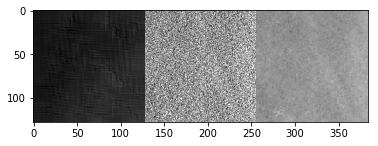

In [14]:
index = random.randint(0, len(all_outputs))
plt.imshow(np.concatenate([all_outputs[index, 0, 0, :, :], content_batch[index, 0, :, :,], style_batch[index, 0, :, :,]], axis=-1), cmap='gray')

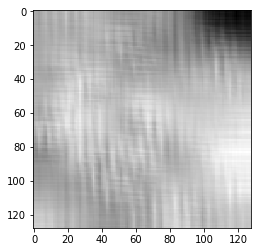

In [22]:
index = random.randint(0, len(all_outputs)-1)
plt.imshow(all_outputs[index, 0, 0, :, :], cmap='gray')

(array([16290.,  3009.,  1380.,   450.,  7413., 14325.,  3291.,  1794.,
         1053.,   147.]),
 array([0.     , 0.01617, 0.03235, 0.04852, 0.0647 , 0.0809 , 0.09705,
        0.1132 , 0.1294 , 0.1455 , 0.1617 ], dtype=float16),
 <a list of 10 Patch objects>)

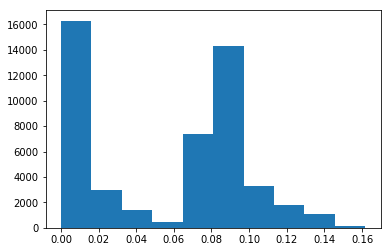

In [10]:
plt.hist(content_batch[0].flatten())

(array([15993.,  3246.,  1464.,   405.,  1011., 19722.,  3744.,  1950.,
         1404.,   213.]),
 array([0.     , 0.01555, 0.0311 , 0.04666, 0.0622 , 0.07776, 0.0933 ,
        0.1089 , 0.1244 , 0.14   , 0.1555 ], dtype=float16),
 <a list of 10 Patch objects>)

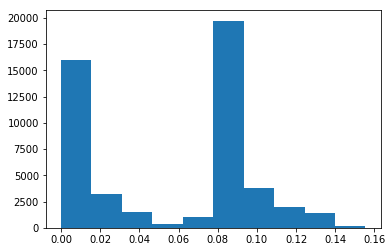

In [11]:
plt.hist(style_batch[0].flatten())

(array([ 6303.,  4900.,  6754., 10048., 15484.,  3806.,  1292.,   369.,
          150.,    46.]),
 array([0.00293089, 0.01996032, 0.03698975, 0.05401919, 0.07104862,
        0.08807805, 0.10510749, 0.12213692, 0.13916636, 0.15619579,
        0.17322522], dtype=float32),
 <a list of 10 Patch objects>)

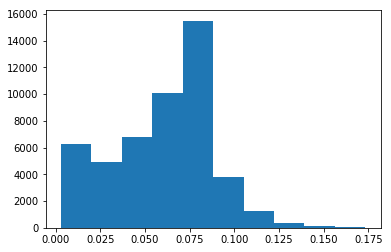

In [9]:
plt.hist(all_outputs[0].flatten())

In [31]:
index = random.randint(0, len(all_outputs)-1)
print(np.mean(all_outputs[index]), np.mean(content_batch[index]), np.mean(style_batch[index]))

0.071999006 0.0911 0.0911
